# SABR model definition

Under the SABR (stochastic $\alpha, \beta, \rho$) model the stock price is governed by the following system of SDE:
$$
\begin{aligned}
&dF_t = \sigma_t F_t^{\beta} dW_t\\
&d\sigma_t = \alpha \sigma_t dZ_t\\
&dW_t dZ_t = \rho dt
\end{aligned}
$$with initial conditions $F_0, \sigma_0$.
The parameters satisfy conditions $0 \leq \beta \leq 1$, $\alpha \geq 0$, $-1 \leq \rho \leq 1$

Let us introduce the small parameter $\varepsilon = \alpha^2 T$

Then we can write asymptotic expantion for implied volatility $\sigma_{imp}$
$$
\sigma_{imp} = \alpha \dfrac{\log \left(F_0/K\right)}{D(\zeta, \rho)} \left[1 + \left(q_1 + q_2 + q_3\right)\varepsilon \right]
$$where
$$
\begin{aligned}
&\zeta = \dfrac{\alpha}{\sigma_0 \left(1-\beta\right)}\left( F_0^{1-\beta} - K^{1-\beta}\right)\\
&D(\zeta, \rho) = \log \dfrac{\sqrt{1 - 2\rho\zeta+\zeta^2} + \zeta - \rho}{1 - \rho}\\
&q_1 = F_m^{2\beta - 2} \dfrac{\sigma_0^2 \left(\beta-1\right)^2}{24 \alpha^2}\\
&q_2 = \dfrac{\rho \sigma_0 \beta}{4\alpha}F_m^{\beta-1}\\
&q_3 = \dfrac{2 - 3 \rho^2}{24}
\end{aligned}
$$And $F_m = \sqrt{ F_0 K }$ and $X_0 = \log F_0, X_m = \log F_m$

In order to calibrate this model to market data we should find derivatives with respect to parameters $\sigma_0, \alpha, \beta, \rho$.

Let us denote
$$
S = 1 + \alpha^2 T(q_1 + q_2 + q_3), 
$$so
$$
\sigma_{impl} = \alpha \dfrac{\log \left(F_0/K\right)}{D(\zeta, \rho)} S.
$$

$$
\begin{aligned}
&\dfrac{\partial \sigma_{impl}}{\partial \sigma_0} = -\dfrac{\sigma_{impl}}{D} \dfrac{\partial D}{\partial \zeta} \dfrac{\partial \zeta}{\partial \sigma_0} + \alpha \dfrac{\log (F_0/K)}{D} \dfrac{\partial S}{\partial \sigma_0}\\
&\dfrac{\partial \sigma_{impl}}{\partial \alpha} = \dfrac{\sigma_{impl}}{\alpha} - \dfrac{\sigma_{impl}}{D}\dfrac{\partial D}{\partial \zeta} \dfrac{\partial \zeta}{\partial \alpha} + \alpha \dfrac{\log (F_0/K) }{D} 
\dfrac{\partial S}{\partial \alpha}\\
&\dfrac{\partial \sigma_{impl}}{\partial \beta} = -\dfrac{\sigma_{impl}}{D} \dfrac{\partial D}{\partial \zeta}
\dfrac{\partial \zeta}{\partial \beta} + \alpha \dfrac{\log(F_0/K)}{D} \dfrac{\partial S}{\partial \beta}\\
&\dfrac{\partial \sigma_{impl}}{\partial\rho} = -\dfrac{\sigma_{impl}}{D}\dfrac{\partial D}{\partial\rho}
    + \dfrac{\alpha \log(F_0/K)}{D} \dfrac{\partial S}{\partial\rho}\\
\end{aligned}
$$

The hardest derivative is the derivative with respect to $\beta$, so:
$$
\begin{aligned}
    &\dfrac{\partial q_1}{\partial \beta} = \dfrac{2 q_1}{\beta - 1} + 2 \log F_m q_1\\
    &\dfrac{\partial q_1}{\partial \beta} = \dfrac{q_2}{\beta} + \log F_m q_1\\
\end{aligned}
$$
For $S$ we have:
$$
\begin{aligned}
&\dfrac{\partial S}{\partial \sigma_0} = \dfrac{\alpha^2 T}{\sigma_0} \left[ 2q_1 + q_2 \right]\\
&\dfrac{\partial S}{\partial \alpha} = 2 \alpha T (q_1 + q_2 + q_3) + \alpha^2 T \left( -\dfrac{2q_1}{\alpha} - \dfrac{q_2}{\alpha}  \right) = \alpha T \left( q_2 + 2 q_3 \right)\\
&\dfrac{\partial S}{\partial \beta} = \alpha^2 T\left( 2q_1 \left[  \dfrac{1}{\beta - 1} + \log F_m \right] 
+ q_2 \left[ \dfrac{1}{\beta} + \log F_m \right] \right)\\
&\dfrac{\partial S}{\partial\rho} = \alpha^2 T \left( \dfrac{q_2}{\rho} - \dfrac{\rho}{4} \right)\\
\end{aligned}$$

For D: 
$$
\begin{aligned}
&\dfrac{\partial D}{\partial \zeta} = \dfrac{1}{\sqrt{1 - 2 \rho \zeta + \zeta^2}}\\
&\dfrac{\partial D}{\partial \rho} = \dfrac{1}{1-\rho} - \dfrac{1 + \dfrac{\zeta}{\sqrt{ 1 - 2\rho \zeta + \zeta^2 }}}{ \sqrt{ 1 - 2\rho \zeta + \zeta^2 } + \zeta - \rho}
= \dfrac{1}{1-\rho} - \dfrac{1}{\sqrt{\ldots}}\dfrac{\sqrt{\ldots} + \zeta}{\sqrt{\ldots} + \zeta - \rho} \\
\end{aligned}
$$

And for $\zeta$:

$$
\begin{aligned}
&\dfrac{\partial \zeta}{\partial \sigma_0} = -\dfrac{\zeta}{\sigma_0}\\
&\dfrac{\partial \zeta}{\partial \alpha} = \dfrac{\zeta}{\alpha}\\
&\dfrac{\partial \zeta}{\partial \beta} = \dfrac{\zeta}{1-\beta} - \dfrac{\alpha}{\sigma_0 \left(1-\beta\right)}\left( \log F_0 F_0^{1-\beta} - \log K K^{1-\beta}\right)
\end{aligned}
$$


In [1]:
import sys
sys.path.append('../../SABR/')
sys.path.append('../../heston/')
sys.path.append('../../heston/heston calibration/')
sys.path.append('../../')

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats as sps

from sabr_approx import *
from nonlinear_optimization import NonlinearOptimization

from heston import *
from heston_calibration import *

In [3]:
def SabrApproxTest(K, F0, r, tau, sig0, alpha, beta, rho):
    Fm = np.sqrt( F0 * K )
    eps = alpha ** 2 * T
    
    zeta = alpha / (sig0) / (1 - beta) * ( F0 ** (1-beta) - K ** (1-beta) )
    D = np.log( (np.sqrt(1 - 2 * rho * zeta + zeta ** 2) + zeta - rho) / (1-rho) )
    
    q1 = Fm ** (2 * beta - 2) * ( sig0 * (1-beta) / alpha ) ** 2 / 24
    q2 = rho * sig0 * beta / 4 / alpha * Fm ** (beta - 1)
    q3 = (2 - 3 * rho ** 2) / 24
    
    vol = alpha * np.log(F0 / K) / D * ( 1 + (q1 + q2 + q3) * eps )
    call_price =  BS(K, F0, r, tau, vol, )
    return call_price, vol


def SabrApproxDerivatives(K, F0, r, tau, sig0, alpha, beta, rho):
    
    #mid point
    Fm = np.sqrt( F0 * K )
    #small parameter
    eps = alpha ** 2 * T
    
    #zeta
    zeta = alpha / (sig0) / (1 - beta) * ( F0 ** (1-beta) - K ** (1-beta) )
    
    zeta_sig0 = -zeta / sig0
    
    zeta_alpha = zeta / alpha
    
    zeta_beta = zeta / (1 - beta) - alpha / (sig0 * (1-beta)) * \
    ( np.log(F0) * F0 ** (1-beta) - np.log(K) * K ** (1-beta))
    
    #D(zeta)
    sqr = np.sqrt(1 - 2 * rho * zeta + zeta ** 2)       
    
    D = np.log( (sqr + zeta - rho) / (1-rho) )
    
    D_zeta = 1 / sqr
    
    D_rho = 1 / (1-rho) - (sqr + zeta) / sqr / (sqr + zeta - rho)
    
    #
    q1 = Fm ** (2 * beta - 2) * ( sig0 * (1-beta) / alpha ) ** 2 / 24
    q2 = rho * sig0 * beta / 4 / alpha * Fm ** (beta - 1)
    q3 = (2 - 3 * rho ** 2) / 24
    
    #S
    S = 1 + eps * (q1 + q2 + q3)
    
    S_sig0 = eps / sig0 * (2 * q1 + q2)
    
    S_alpha = alpha * T * (q2 + 2 * q3)
    
    S_beta  = eps * ( 2 * q1 * ( 1 / (beta - 1)  + np.log(Fm)) + q2 * ( 1 / beta + np.log(Fm)) )
    
    S_rho = eps * (Fm ** (beta - 1) * sig0 * beta / (4 * alpha) - rho / 4 )
    
    #result
    vol = alpha * np.log(F0 / K) / D * S
    
    vol_sig0 = -vol / D *  D_zeta * zeta_sig0 + alpha * np.log(F0/K) / D  * S_sig0 
    
    vol_alpha = vol / alpha - vol / D * D_zeta * zeta_alpha + alpha * np.log(F0 / K) / D * S_alpha
    
    vol_beta = -vol / D * D_zeta * zeta_beta + alpha * np.log(F0/K) / D * S_beta
    
    vol_rho = -vol / D * D_rho + alpha * np.log(F0/K) / D * S_rho
    
    return vol, vol_sig0, vol_alpha, vol_beta, vol_rho 

In [4]:
F0 = 1
K = F0 * 1.5

alpha = 0.15
beta = 0.25
rho = 0.25

r = 0.0

T = 0.5

sig0 = 0.3

In [5]:
C, iv = SabrApprox(K, F0, r, T, sig0, alpha, beta, rho)

C1, iv1 = SabrApproxTest(K, F0, r, T, sig0, alpha, beta, rho)

print(C-C1, iv - iv1)


0.0 0.0


9.720636767764745e-09

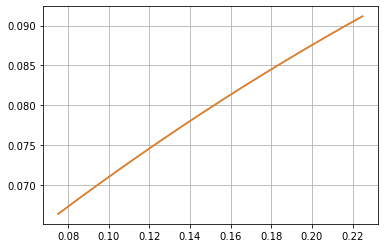

In [6]:
alphan = alpha * np.linspace(0.5, 1.5, 1000)
h = alphan[1] - alphan[0]

vol, der_sig0, der_alpha, der_beta, der_rho  = SabrApproxDerivatives(K, F0, r, T, sig0, alphan[:-1] + h/2, beta, rho)

_, vol = SabrApproxTest(K, F0, r, T, sig0, alphan, beta, rho)

der_finite = np.diff(vol) / h

plt.plot(alphan[:-1] + h/2, der_alpha)
plt.plot(alphan[:-1] + h/2, der_finite)
plt.grid()

np.linalg.norm(der_alpha - der_finite)

6.422193996626124e-09

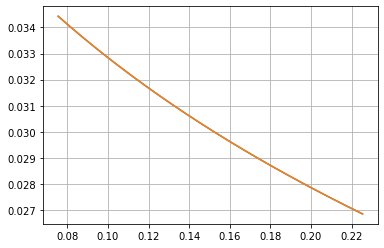

In [7]:
rhon = np.linspace(-0.5, 0.5, 1000)
h = rhon[1] - rhon[0]

vol, der_sig0, der_alpha, der_beta, der_rho = SabrApproxDerivatives(K, F0, r, T, sig0, alpha, beta, rhon[:-1] + h/2)

_, vol = SabrApproxTest(K, F0, r, T, sig0, alpha, beta, rhon)

der_finite = np.diff(vol) / h

plt.plot(alphan[:-1] + h/2, der_rho)
plt.plot(alphan[:-1] + h/2, der_finite)
plt.grid()

np.linalg.norm(der_rho - der_finite)

9.68496726932121e-08

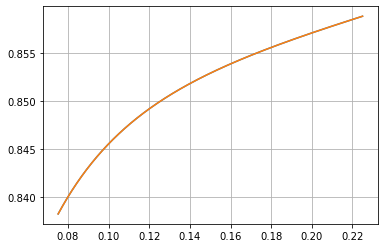

In [8]:
sign = sig0 * np.linspace(0.5, 1.5, 1000)
h = sign[1] - sign[0]

vol, der_sig0, der_alpha, der_beta, der_rho= SabrApproxDerivatives(K, F0, r, T, sign[:-1] + h/2, alpha, beta, rho)

_, vol = SabrApproxTest(K, F0, r, T, sign, alpha, beta, rho)

der_finite = np.diff(vol) / h

plt.plot(alphan[:-1] + h/2, der_sig0)
plt.plot(alphan[:-1] + h/2, der_finite)
plt.grid()

np.linalg.norm(der_sig0 - der_finite)

1.92961314608098e-09

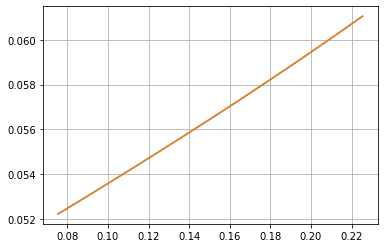

In [9]:
betan = np.linspace(0.01, 0.99, 1000)
h = betan[1] - betan[0]

vol, der_sig0, der_alpha, der_beta, der_rho = SabrApproxDerivatives(K, F0, r, T, sig0, alpha, betan[:-1]+h/2, rho)

_, vol = SabrApproxTest(K, F0, r, T, sig0, alpha, betan, rho)

der_finite = np.diff(vol) / h

plt.plot(alphan[:-1] + h/2, der_beta)
plt.plot(alphan[:-1] + h/2, der_finite)
plt.grid()

np.linalg.norm(der_beta - der_finite)

In [127]:
F0 = 1
K = F0 * 1.5

alpha = 0.15
beta = 0.25
rho = 0.25

r = 0.0

T = 0.5

sig0 = 0.3


Kn = np.linspace(0.5, 1.5, 16) * F0

c0, iv0 = SabrApproxTest(Kn, F0, r, T, sig0, alpha, beta, rho)

sabr_params_0 = np.asarray( [sig0, alpha, beta, rho] )

In [128]:
def gen_random_sabr_params():
    eps = 1e-5
    sig0 = 0.3 * np.random.rand(1) + eps
    alpha = 1.0 * np.random.rand(1) + eps
    beta = 0.1 + 0.8 * np.random.rand(1)
    rho = -0.9 + (1.8) * np.random.rand(1)
    return np.asarray([sig0[0], alpha[0], beta[0], rho[0]] )

In [129]:
def proj( sabr_params ):
    sig0, alpha, beta, rho = sabr_params
    
    eps = 1e-6
    
    sig0 = max(sig0, eps)
    alpha = max(alpha, eps)
    rho = np.clip(rho, -1 + eps, 1 - eps)
    beta = np.clip(beta, eps, 1 - eps)
    
    return np.asarray( [sig0, alpha, beta, rho] )

In [130]:
def optimize_sabr( iv0, Niter=100, weights=None ):
    if weights is None:
        weights = np.ones_like(iv0)
    weights = weights / np.sum(weights)
    def get_error( sabr_params ):
        sig0, alpha, beta, rho = sabr_params

        iv, d1, d2, d3, d4 = SabrApproxDerivatives(Kn, F0, r, T, sig0, alpha, beta, rho)

        res = iv - iv0

        J = np.asarray( [d1, d2, d3, d4] )

        return res * weights, J @ np.diag(weights)
    sabr_params, fs = NonlinearOptimization(Niter, get_error, proj, gen_random_sabr_params())
    
    return sabr_params, fs

In [131]:
sabr_params, fs = optimize_sabr( iv0 )

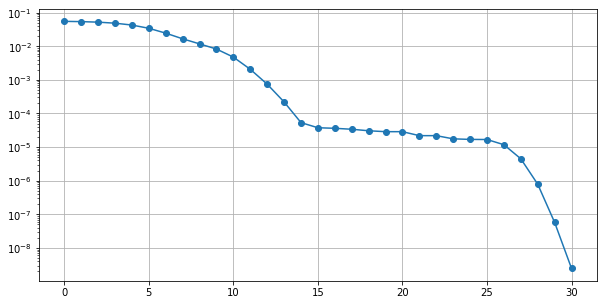

In [132]:
plt.figure(figsize=(10, 5))
plt.semilogy(fs, '-o')
plt.grid()

In [133]:
sabr_params_0

array([0.3 , 0.15, 0.25, 0.25])

In [134]:
sabr_params

array([0.3       , 0.15000009, 0.25000061, 0.2499986 ])

In [135]:
v0_0    = 1.75
theta_0 = 0.2
rho_0   = 0.5
k_0     = 2.0
sig_0   = 0.5

heston_params_0 = np.asarray( [v0_0, theta_0, rho_0, k_0, sig_0] )

In [136]:
c_heston = getOptionPriceAB(F0, Kn, T, 200, r, *heston_params_0)

In [137]:
from implied_volatility import getIV

In [138]:
iv_heston = getIV(c_heston, Kn, F0, r, T)

In [139]:
weights = 1 / (0.01 + np.abs(Kn - F0))

In [140]:
sabr_params, fs = optimize_sabr( iv_heston, Niter=30, weights=weights )

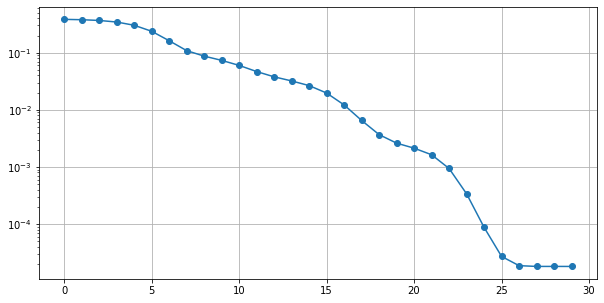

In [141]:
plt.figure(figsize=(10, 5))
plt.semilogy(fs, '-o')
plt.grid()

In [142]:
c_calibrated, iv_calibrated = SabrApproxTest(Kn, F0, r, T, *sabr_params)

In [143]:
np.linalg.norm(iv_calibrated - iv_heston)

0.0005874645994074658

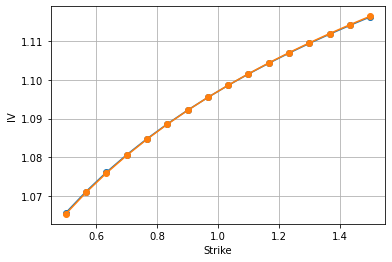

In [144]:
plt.plot(Kn, iv_calibrated, '-o')
plt.plot(Kn, iv_heston, '-o')
plt.xlabel('Strike')
plt.ylabel('IV')
plt.grid()

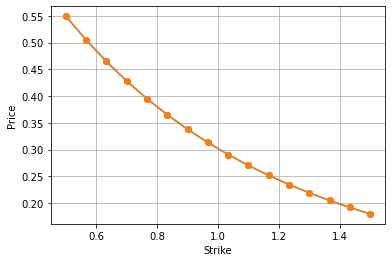

In [145]:
plt.plot(Kn, c_calibrated, '-o')
plt.plot(Kn, c_heston, '-o')
plt.xlabel('Strike')
plt.ylabel('Price')
plt.grid()